To begin copy this notebook to your own drive:

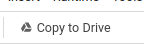


### Submission Instructions:
1. **Restart the kernel** (in the menubar, select Runtime$\rightarrow$Restart runtime)
2. **Download the notebook** (in the menubar, select File$\rightarrow$Download .ipynb)
3. **Upload the downloaded notebook (.ipynb file) to your repository**.


Make sure you fill in any place that says `YOUR CODE HERE`, and that no tests fail.  

Note: To use a GPU, do the following: Runtime$\rightarrow$Change runtime type$\rightarrow$ GPU

In [1]:
import gdown
import nltk
gdown.download('https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn', 'glove.npy', quiet=False)
gdown.download('https://drive.google.com/uc?export=download&id=1-3SxpirQjmX-RCRyRjKdP2L7G_tNgp00', 'vocab.json', quiet=False)

nltk.download('punkt')

Downloading...
From: https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn
To: /content/glove.npy
100%|██████████| 480M/480M [00:05<00:00, 95.7MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1-3SxpirQjmX-RCRyRjKdP2L7G_tNgp00
To: /content/vocab.json
100%|██████████| 7.69M/7.69M [00:00<00:00, 52.5MB/s]
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
!pip install datasets
!pip install transformers
!pip install --upgrade accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 4.3 MB/s eta 0:00:00


In [ ]:
!pip install prettytable

In [ ]:
from prettytable import PrettyTable

In [3]:
import numpy as np
from datasets import load_dataset


raw_datasets = load_dataset("imdb")


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [4]:

from nltk.tokenize import word_tokenize
import json

with open("vocab.json") as f:
  vocab = json.load(f)

def tokenize_function(example):
  sentences = [x.lower() for x in example['text']]
  tokenized_sentences = [word_tokenize(x) for x in sentences]
  tokenized_idx = [[vocab[word] if word in vocab else vocab["unk"] for word in x] for x in tokenized_sentences]
  max_size = max([len(x) for x in tokenized_idx])
  final_tokenized_idx = tokenized_idx

  return {"labels":example['label'],'input_ids':final_tokenized_idx}

In [5]:
small_train_dataset = raw_datasets['train'].shuffle(seed=42).map(tokenize_function,batched=True)
small_eval_dataset = raw_datasets['test'].shuffle(seed=42).map(tokenize_function,batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [6]:
def pad_sequence_to_length(
    sequence,
    desired_length: int,
    default_value = lambda: 0,
    padding_on_right: bool = True,
):
    sequence = list(sequence)
    # Truncates the sequence to the desired length.
    if padding_on_right:
        padded_sequence = sequence[:desired_length]
    else:
        padded_sequence = sequence[-desired_length:]
    # Continues to pad with default_value() until we reach the desired length.
    pad_length = desired_length - len(padded_sequence)
    # This just creates the default value once, so if it's a list, and if it gets mutated
    # later, it could cause subtle bugs. But the risk there is low, and this is much faster.
    values_to_pad = [default_value()] * pad_length
    if padding_on_right:
        padded_sequence = padded_sequence + values_to_pad
    else:
        padded_sequence = values_to_pad + padded_sequence
    return padded_sequence

In [7]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits = eval_pred.predictions
    labels = eval_pred.label_ids
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

<ipython-input-7-c6aba47c7ef1>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [8]:
from dataclasses import dataclass

@dataclass
class DataCollatorWithPadding:

  def __call__(self, features):
    features_dict={}
    if "labels" in features[0]:

      features_dict["labels"] = torch.tensor([x.pop("labels") for x in features]).long()

    input_ids = [x.pop("input_ids") for x in features]
    max_len = max(len(x) for x in input_ids)
    masks = [[1]*len(x) for x in input_ids]

    features_dict["input_ids"] = torch.tensor([pad_sequence_to_length(x,max_len) for x in input_ids]).long()
    features_dict["attention_masks"] = torch.tensor([pad_sequence_to_length(x,max_len) for x in masks]).long()

    return features_dict


In [9]:
from torch import nn
import torch
#Use nn.Sequential and nn.Linear for the network, and nn.CrossEntropyLoss for the loss.
#Make sure that the final layer has output dimension of size 2.
class DAN(nn.Module):
  def __init__(self):
          super().__init__()
          self.num_labels = 2
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
          # YOUR CODE HERE
          self.embedding_size=self.embeddings.embedding_dim
          self.hidden_size=300
          self.classifier = nn.Sequential(
            nn.Linear(self.embedding_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.num_labels),
            nn.Softmax(dim=1)
        )

          self.loss = nn.CrossEntropyLoss()
          # END YOUR END



  def forward(self,input_ids,attention_masks,labels=None,**kwargs):
      # YOUR CODE HERE
      embedding_vectors = self.embeddings(input_ids)
      avg = torch.mean(embedding_vectors, dim=1)


      # END YOUR END
      res = self.classifier(avg)
      loss = self.loss(res,labels)
      return {"loss":loss,"logits":res}



In [15]:
#Hint: You may want to look at https://huggingface.co/transformers/main_classes/callback.html
from transformers import Trainer
from transformers import TrainingArguments
from transformers import EarlyStoppingCallback, TrainerCallback

co = DataCollatorWithPadding()
training_args = TrainingArguments("DAN",
                                  # YOUR CODE HERE
                                  num_train_epochs= 25, #must be at least 10.
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=16,
                                  learning_rate= 1e-3,
                                  # END YOUR END

                                  save_total_limit=2,
                                  log_level="error",
                                  evaluation_strategy="epoch")
model = DAN()




eval_accuracies = []


class MyCallback(TrainerCallback):
    "A callback that prints a message at the beginning of training"
    def __init__(self, save_total_limit=1):
        super().__init__()
        self.save_total_limit = save_total_limit
        self.best_accuracy = -1  # Initialize with a value lower than any possible accuracy
        self.checkpoints = []

    def on_train_begin(self, args, state, control, **kwargs):
        print("Starting training")

    def on_epoch_end(self, args, state, control, **kwargs):
      print("end epoch")


# Instantiate the Trainer
trainer = Trainer(
    model=model,
    data_collator=co,
    args=training_args,
    callbacks=[

    ],
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

trainer.add_callback(MyCallback)



In [16]:
trainer.train()

Starting training
{'loss': 0.608, 'learning_rate': 0.0009872040946896992, 'epoch': 0.32}
{'loss': 0.5322, 'learning_rate': 0.0009744081893793985, 'epoch': 0.64}
{'loss': 0.5126, 'learning_rate': 0.0009616122840690979, 'epoch': 0.96}
end epoch
{'eval_loss': 0.6467989683151245, 'eval_accuracy': 0.66124, 'eval_runtime': 12.6629, 'eval_samples_per_second': 1974.268, 'eval_steps_per_second': 123.431, 'epoch': 1.0}
{'loss': 0.5199, 'learning_rate': 0.0009488163787587972, 'epoch': 1.28}
{'loss': 0.5037, 'learning_rate': 0.0009360204734484965, 'epoch': 1.6}
{'loss': 0.5076, 'learning_rate': 0.0009232245681381958, 'epoch': 1.92}
end epoch
{'eval_loss': 0.49123668670654297, 'eval_accuracy': 0.81176, 'eval_runtime': 13.209, 'eval_samples_per_second': 1892.655, 'eval_steps_per_second': 118.329, 'epoch': 2.0}
{'loss': 0.4935, 'learning_rate': 0.000910428662827895, 'epoch': 2.24}
{'loss': 0.4966, 'learning_rate': 0.0008976327575175944, 'epoch': 2.56}
{'loss': 0.4997, 'learning_rate': 0.0008848368522

TrainOutput(global_step=39075, training_loss=0.475060576123453, metrics={'train_runtime': 920.7182, 'train_samples_per_second': 678.818, 'train_steps_per_second': 42.44, 'train_loss': 0.475060576123453, 'epoch': 25.0})

{'eval_loss': 0.470064252614975, 'eval_accuracy': 0.83544, 'eval_runtime': 13.2676, 'eval_samples_per_second': 1884.283, 'eval_steps_per_second': 117.805, 'epoch': 25.0}
[0.66124, 0.81176, 0.66344, 0.8078, 0.824, 0.82608, 0.8292, 0.82696, 0.81996, 0.82804, 0.83068, 0.83068, 0.82796, 0.83072, 0.83212, 0.8308, 0.83312, 0.83072, 0.82604, 0.83328, 0.83256, 0.81948, 0.83508, 0.83416, 0.83544, 0.83544]
0.83544


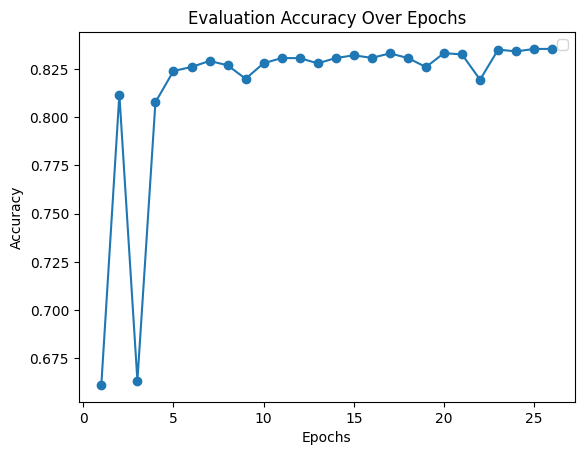

In [17]:
import matplotlib.pyplot as plt

eval_results = trainer.evaluate()

#print(trainer.state.log_history)
data = trainer.state.log_history
eval_accuracies = [entry.get('eval_accuracy') for entry in data if 'eval_accuracy' in entry]
print(eval_accuracies)

# Assuming 'accuracy' is the correct key
accuracy_key = 'eval_accuracy'
print(eval_results[accuracy_key])
x_values = list(range(1, len(eval_accuracies) + 1))

# Plotting the 'eval_accuracy' values
plt.plot(x_values, eval_accuracies, marker='o', linestyle='-')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Evaluation Accuracy Over Epochs")
plt.legend()
plt.show()


#section B

In [ ]:
class DAN2(nn.Module):
  def __init__(self, prob):
          super().__init__()
          self.num_labels = 2
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
          # YOUR CODE HERE
          self.prob = prob
          self.word_dropout = nn.Dropout(p=prob)
          self.embedding_size=self.embeddings.embedding_dim
          self.hidden_size=150
          self.classifier = nn.Sequential(
            nn.Linear(self.embedding_size, self.hidden_size),
            nn.Linear(self.hidden_size, self.num_labels),
            nn.Softmax(dim=1)

        )

          self.loss = nn.CrossEntropyLoss()
          # END YOUR END



  def forward(self,input_ids,attention_masks,labels=None,**kwargs):
      # YOUR CODE HERE
      embedding_vectors = self.embeddings(input_ids)
      embedding_vectors = self.word_dropout(embedding_vectors)
      avg = torch.mean(embedding_vectors, dim=1)
      # END YOUR END
      res = self.classifier(avg)
      loss = self.loss(res,labels)
      return {"loss":loss,"logits":res}

In [ ]:
co = DataCollatorWithPadding()
training_args2 = TrainingArguments("DAN2",
                                  # YOUR CODE HERE
                                  num_train_epochs= 10, #must be at least 10.
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=16,
                                  learning_rate= 1e-3,
                                  # END YOUR END

                                  save_total_limit=2,
                                  log_level="error",
                                  evaluation_strategy="epoch")

eval_accuracies2 = []
probs2 = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
for prob in probs2:
      model2 = DAN2(prob)
      class MyCallback(TrainerCallback):
          "A callback that prints a message at the beginning of training"
          def __init__(self, save_total_limit=1):
              super().__init__()
              self.save_total_limit = save_total_limit
              self.best_accuracy = -1  # Initialize with a value lower than any possible accuracy
              self.checkpoints = []

          def on_train_begin(self, args, state, control, **kwargs):
              print("Starting training")

          def on_epoch_end(self, args, state, control, **kwargs):
            print("end epoch")


      # Instantiate the Trainer
      trainer2 = Trainer(
          model=model2,
          data_collator=co,
          args=training_args2,
          callbacks=[

          ],
          train_dataset=small_train_dataset,
          eval_dataset=small_eval_dataset,
          compute_metrics=compute_metrics,
      )

      trainer2.add_callback(MyCallback)

      trainer2.train()


      eval_results2 = trainer2.evaluate()
      # Assuming 'accuracy' is the correct key
      accuracy_key2 = 'eval_accuracy'
      eval_accuracies2.append(eval_results2[accuracy_key])



Starting training
{'loss': 0.6328, 'learning_rate': 0.0009680102367242482, 'epoch': 0.32}
{'loss': 0.5386, 'learning_rate': 0.0009360204734484965, 'epoch': 0.64}
{'loss': 0.5172, 'learning_rate': 0.0009040307101727447, 'epoch': 0.96}
end epoch
{'eval_loss': 0.5148758888244629, 'eval_accuracy': 0.79516, 'eval_runtime': 23.8509, 'eval_samples_per_second': 1048.178, 'eval_steps_per_second': 65.532, 'epoch': 1.0}
{'loss': 0.5004, 'learning_rate': 0.000872040946896993, 'epoch': 1.28}
{'loss': 0.4978, 'learning_rate': 0.0008400511836212412, 'epoch': 1.6}
{'loss': 0.496, 'learning_rate': 0.0008080614203454894, 'epoch': 1.92}
end epoch
{'eval_loss': 0.4909297227859497, 'eval_accuracy': 0.81632, 'eval_runtime': 25.3713, 'eval_samples_per_second': 985.365, 'eval_steps_per_second': 61.605, 'epoch': 2.0}
{'loss': 0.4852, 'learning_rate': 0.0007760716570697377, 'epoch': 2.24}
{'loss': 0.4866, 'learning_rate': 0.0007440818937939859, 'epoch': 2.56}
{'loss': 0.4889, 'learning_rate': 0.0007120921305182

In [ ]:
print(eval_accuracies)

[0.83016, 0.82916, 0.82808, 0.82796, 0.82664, 0.82236]


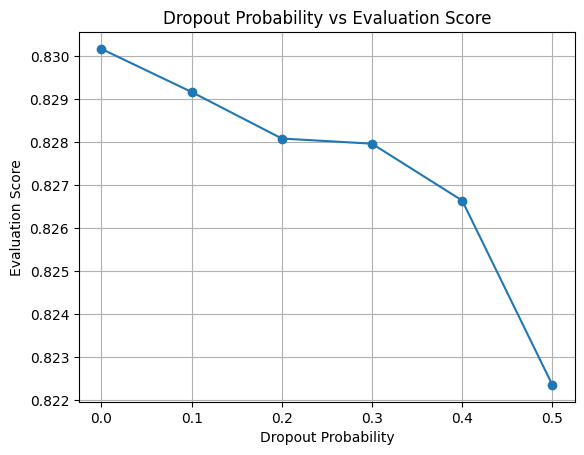

In [ ]:
plt.plot(probs, eval_accuracies, marker='o', linestyle='-')
plt.title('Dropout Probability vs Evaluation Score')
plt.xlabel('Dropout Probability')
plt.ylabel('Evaluation Score')
plt.grid(True)
plt.show()

#Section C

In [ ]:
class DAN3(nn.Module):
  def __init__(self, hidden_layers):
          super().__init__()
          self.num_labels = 2
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
          # YOUR CODE HERE
          self.hidden_layers = hidden_layers
          self.embedding_size=self.embeddings.embedding_dim
          self.hidden_size=150
          self.zero_layers = nn.Linear(self.embedding_size, self.num_labels)
          self.softmax_func = nn.Softmax(dim=1)
          self.first_linear = nn.Linear(self.embedding_size, self.hidden_size)
          self.linear_layer = nn.Linear(self.hidden_size, self.hidden_size)
          self.final_layer = nn.Linear(self.hidden_size, self.num_labels)
          self.relu = nn.ReLU()


          self.loss = nn.CrossEntropyLoss()
          # END YOUR END



  def forward(self,input_ids,attention_masks,labels=None,**kwargs):
      # YOUR CODE HERE
      embedding_vectors = self.embeddings(input_ids)
      avg = torch.mean(embedding_vectors, dim=1)

      if self.hidden_layers == 0:
        out = self.zero_layers(avg)
        res = self.softmax_func(out)
        loss = self.loss(res,labels)
        return {"loss":loss,"logits":res}

      linear_output = self.first_linear(avg)
      out = self.relu(linear_output)

      for layer in range(self.hidden_layers-1):
          linear_output = self.linear_layer(out)
          out = self.relu(linear_output)

      temp_res = self.final_layer(out)




      # END YOUR END
      res = self.softmax_func(temp_res)
      loss = self.loss(res,labels)
      return {"loss":loss,"logits":res}

In [ ]:
#Hint: You may want to look at https://huggingface.co/transformers/main_classes/callback.html
from transformers import Trainer
from transformers import TrainingArguments
from transformers import EarlyStoppingCallback, TrainerCallback

co = DataCollatorWithPadding()
training_args3 = TrainingArguments("DAN3",
                                  # YOUR CODE HERE
                                  num_train_epochs= 10, #must be at least 10.
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=16,
                                  learning_rate= 1e-3,
                                  # END YOUR END

                                  save_total_limit=2,
                                  log_level="error",
                                  evaluation_strategy="epoch")
array_layers = [0, 1, 2, 3, 4]
eval_accuracies3 = []
for layer in array_layers:

      model3 = DAN3(layer)

      class MyCallback(TrainerCallback):
          "A callback that prints a message at the beginning of training"
          def __init__(self, save_total_limit=1):
              super().__init__()
              self.save_total_limit = save_total_limit
              self.best_accuracy = -1  # Initialize with a value lower than any possible accuracy
              self.checkpoints = []

          def on_train_begin(self, args, state, control, **kwargs):
              print("Starting training")

          def on_epoch_end(self, args, state, control, **kwargs):
            print("end epoch")


      # Instantiate the Trainer
      trainer3 = Trainer(
          model=model,
          data_collator=co,
          args=training_args,
          callbacks=[

          ],
          train_dataset=small_train_dataset,
          eval_dataset=small_eval_dataset,
          compute_metrics=compute_metrics,
      )

      trainer3.add_callback(MyCallback)

      trainer3.train()

      eval_results3 = trainer3.evaluate()
      # Assuming 'accuracy' is the correct key
      accuracy_key3 = 'eval_accuracy'
      print(eval_results3[accuracy_key3])
      eval_accuracies3.append(eval_results3[accuracy_key3])
      print(eval_accuracies3)




Starting training
{'loss': 0.6829, 'learning_rate': 0.0009360613810741688, 'epoch': 0.64}
end epoch
{'eval_loss': 0.668164849281311, 'eval_accuracy': 0.64812, 'eval_runtime': 28.4414, 'eval_samples_per_second': 879.001, 'eval_steps_per_second': 27.495, 'epoch': 1.0}
{'loss': 0.6663, 'learning_rate': 0.0008721227621483376, 'epoch': 1.28}
{'loss': 0.6579, 'learning_rate': 0.0008081841432225064, 'epoch': 1.92}
end epoch
{'eval_loss': 0.6545807123184204, 'eval_accuracy': 0.6702, 'eval_runtime': 27.9264, 'eval_samples_per_second': 895.212, 'eval_steps_per_second': 28.002, 'epoch': 2.0}
{'loss': 0.6489, 'learning_rate': 0.0007442455242966752, 'epoch': 2.56}
end epoch
{'eval_loss': 0.6461842060089111, 'eval_accuracy': 0.67936, 'eval_runtime': 27.9426, 'eval_samples_per_second': 894.69, 'eval_steps_per_second': 27.986, 'epoch': 3.0}
{'loss': 0.6445, 'learning_rate': 0.000680306905370844, 'epoch': 3.2}
{'loss': 0.6399, 'learning_rate': 0.0006163682864450127, 'epoch': 3.84}
end epoch
{'eval_loss

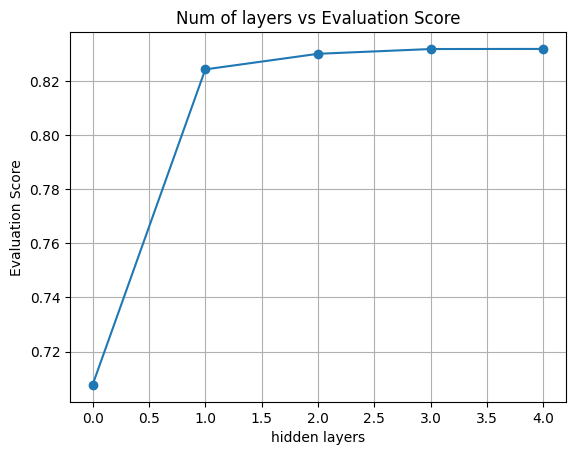

In [ ]:
plt.plot(array_layers, eval_accuracies, marker='o', linestyle='-')
plt.title('Num of layers vs Evaluation Score')
plt.xlabel('hidden layers')
plt.ylabel('Evaluation Score')
plt.grid(True)
plt.show()

#Section D

In [ ]:
class DAN4(nn.Module):
  def __init__(self):
          super().__init__()
          self.num_labels = 2
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
          # YOUR CODE HERE
          self.embedding_size=self.embeddings.embedding_dim
          self.hidden_size=150
          self.classifier = nn.Sequential(
            nn.Linear(self.embedding_size, self.hidden_size),
            nn.SELU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.Hardsigmoid(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.num_labels),
            nn.Softmax(dim=1)

          )

          self.loss = nn.CrossEntropyLoss()
          # END YOUR END



  def forward(self,input_ids,attention_masks,labels=None,**kwargs):
      # YOUR CODE HERE
      embedding_vectors = self.embeddings(input_ids)
      avg = torch.mean(embedding_vectors, dim=1)


      # END YOUR END
      res = self.classifier(avg)
      loss = self.loss(res,labels)
      return {"loss":loss,"logits":res}

In [ ]:
#Hint: You may want to look at https://huggingface.co/transformers/main_classes/callback.html
from transformers import Trainer
from transformers import TrainingArguments
from transformers import EarlyStoppingCallback, TrainerCallback

co = DataCollatorWithPadding()
training_args4 = TrainingArguments("DAN4",
                                  # YOUR CODE HERE
                                  num_train_epochs= 10, #must be at least 10.
                                  per_device_train_batch_size=32,
                                  per_device_eval_batch_size=32,
                                  learning_rate= 1e-3,
                                  # END YOUR END

                                  save_total_limit=2,
                                  log_level="error",
                                  evaluation_strategy="epoch")

eval_accuracies4 = []


model4 = DAN4()

class MyCallback(TrainerCallback):
    "A callback that prints a message at the beginning of training"
    def __init__(self, save_total_limit=1):
        super().__init__()
        self.save_total_limit = save_total_limit
        self.best_accuracy = -1  # Initialize with a value lower than any possible accuracy
        self.checkpoints = []

    def on_train_begin(self, args, state, control, **kwargs):
        print("Starting training")

    def on_epoch_end(self, args, state, control, **kwargs):
      print("end epoch")


# Instantiate the Trainer
trainer4 = Trainer(
    model=model,
    data_collator=co,
    args=training_args,
    callbacks=[

    ],
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

trainer4.add_callback(MyCallback)

trainer4.train()

data4 = trainer.state.log_history
eval_accuracies4 = [entry.get('eval_accuracy') for entry in data4 if 'eval_accuracy' in entry]
print(eval_accuracies4)





Starting training
{'loss': 0.5931, 'learning_rate': 0.0009360613810741688, 'epoch': 0.64}
end epoch
{'eval_loss': 0.5258010029792786, 'eval_accuracy': 0.77632, 'eval_runtime': 33.2219, 'eval_samples_per_second': 752.515, 'eval_steps_per_second': 23.539, 'epoch': 1.0}
{'loss': 0.5108, 'learning_rate': 0.0008721227621483376, 'epoch': 1.28}
{'loss': 0.4989, 'learning_rate': 0.0008081841432225064, 'epoch': 1.92}
end epoch
{'eval_loss': 0.5022874474525452, 'eval_accuracy': 0.80116, 'eval_runtime': 34.0273, 'eval_samples_per_second': 734.704, 'eval_steps_per_second': 22.982, 'epoch': 2.0}
{'loss': 0.487, 'learning_rate': 0.0007442455242966752, 'epoch': 2.56}
end epoch
{'eval_loss': 0.4841819405555725, 'eval_accuracy': 0.821, 'eval_runtime': 33.8542, 'eval_samples_per_second': 738.461, 'eval_steps_per_second': 23.099, 'epoch': 3.0}
{'loss': 0.4908, 'learning_rate': 0.000680306905370844, 'epoch': 3.2}
{'loss': 0.4803, 'learning_rate': 0.0006163682864450127, 'epoch': 3.84}
end epoch
{'eval_loss

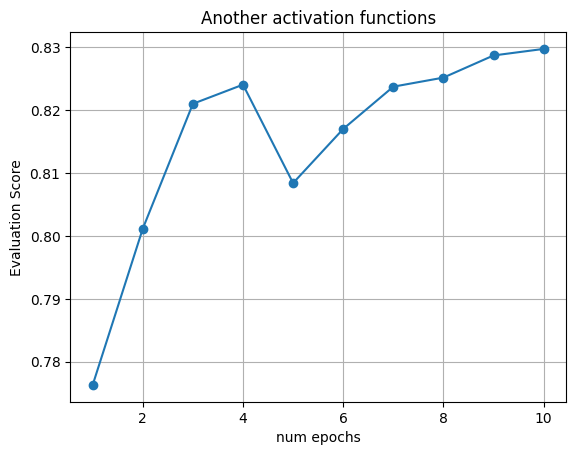

In [ ]:
num_epochs4 = list(range(1, len(eval_accuracies) + 1))

plt.plot(num_epochs4, eval_accuracies4, marker='o', linestyle='-')
plt.title('Another activation functions')
plt.xlabel('num epochs')
plt.ylabel('Evaluation Score')
plt.grid(True)
plt.show()

#Section e

In [ ]:
from torch import nn
import torch

class DAN5(nn.Module):
  def __init__(self, hidden_layers):
          super().__init__()
          self.num_labels = 2
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
          # YOUR CODE HERE
          self.hidden_layers = hidden_layers
          self.embedding_size=self.embeddings.embedding_dim
          self.hidden_size=150
          self.zero_layers = nn.Linear(self.embedding_size, self.num_labels)
          self.softmax_func = nn.Softmax(dim=1)
          self.first_linear = nn.Linear(self.embedding_size, self.hidden_size)
          self.linear_layer = nn.Linear(self.hidden_size, self.hidden_size)
          self.final_layer = nn.Linear(self.hidden_size, self.num_labels)
          self.relu = nn.ReLU()


          self.loss = nn.CrossEntropyLoss()
          # END YOUR END



  def forward(self,input_ids,attention_masks,labels=None,**kwargs):
      # YOUR CODE HERE
      embedding_vectors = self.embeddings(input_ids)
      avg = torch.mean(embedding_vectors, dim=1)

      if self.hidden_layers == 0:
        out = self.zero_layers(avg)
        res = self.softmax_func(out)
        loss = self.loss(res,labels)
        return {"loss":loss,"logits":res}

      linear_output = self.first_linear(avg)
      out = self.relu(linear_output)

      for layer in range(self.hidden_layers-1):
          linear_output = self.linear_layer(out)
          out = self.relu(linear_output)

      temp_res = self.final_layer(out)




      # END YOUR END
      res = self.softmax_func(temp_res)
      loss = self.loss(res,labels)
      return {"loss":loss,"logits":res}



In [ ]:
#Hint: You may want to look at https://huggingface.co/transformers/main_classes/callback.html
from transformers import Trainer
from transformers import TrainingArguments
from transformers import EarlyStoppingCallback, TrainerCallback

co = DataCollatorWithPadding()
training_args5 = TrainingArguments("DAN5",
                                  # YOUR CODE HERE
                                  num_train_epochs= 10, #must be at least 10.
                                  per_device_train_batch_size=32,
                                  per_device_eval_batch_size=32,
                                  learning_rate= 1e-3,
                                  # END YOUR END

                                  save_total_limit=2,
                                  log_level="error",
                                  evaluation_strategy="epoch")

eval_accuracies5 = []
model5 = DAN5(4)

class MyCallback(TrainerCallback):
    "A callback that prints a message at the beginning of training"
    def __init__(self, save_total_limit=1):
        super().__init__()
        self.save_total_limit = save_total_limit
        self.best_accuracy = -1  # Initialize with a value lower than any possible accuracy
        self.checkpoints = []

    def on_train_begin(self, args, state, control, **kwargs):
        print("Starting training")

    def on_epoch_end(self, args, state, control, **kwargs):
      print("end epoch")


# Instantiate the Trainer
trainer5 = Trainer(
    model=model,
    data_collator=co,
    args=training_args5,
    callbacks=[

    ],
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

trainer5.add_callback(MyCallback)

trainer5.train()

eval_results5 = trainer5.evaluate()
# Assuming 'accuracy' is the correct key
accuracy_key5 = 'eval_accuracy'
print(eval_results5[accuracy_key5])
eval_accuracies5.append(eval_results[accuracy_key5])
print(eval_accuracies5)




Starting training
{'loss': 0.475, 'learning_rate': 0.0009360613810741688, 'epoch': 0.64}
end epoch
{'eval_loss': 0.47575002908706665, 'eval_accuracy': 0.83008, 'eval_runtime': 14.3417, 'eval_samples_per_second': 1743.17, 'eval_steps_per_second': 54.526, 'epoch': 1.0}
{'loss': 0.4677, 'learning_rate': 0.0008721227621483376, 'epoch': 1.28}
{'loss': 0.4767, 'learning_rate': 0.0008081841432225064, 'epoch': 1.92}
end epoch
{'eval_loss': 0.49728649854660034, 'eval_accuracy': 0.80792, 'eval_runtime': 14.2404, 'eval_samples_per_second': 1755.569, 'eval_steps_per_second': 54.914, 'epoch': 2.0}
{'loss': 0.4718, 'learning_rate': 0.0007442455242966752, 'epoch': 2.56}
end epoch
{'eval_loss': 0.47485536336898804, 'eval_accuracy': 0.82984, 'eval_runtime': 14.1261, 'eval_samples_per_second': 1769.775, 'eval_steps_per_second': 55.359, 'epoch': 3.0}
{'loss': 0.4717, 'learning_rate': 0.000680306905370844, 'epoch': 3.2}
{'loss': 0.47, 'learning_rate': 0.0006163682864450127, 'epoch': 3.84}
end epoch
{'eval

In [ ]:
#choosing from the fiddrent layers model. the trainer is from there

predictions = trainer5.predict(small_eval_dataset)

logits = predictions.predictions
labels = predictions.label_ids

# Convert logits to probabilities using softmax
probabilities = torch.nn.functional.softmax(torch.tensor(logits), dim=1)




In [ ]:
# Find indices where the predicted class does not match the true class
misclassified_indices = np.where(np.argmax(probabilities.numpy(), axis=1) != labels)

# Display the misclassified samples

arr_section_e = misclassified_indices[0]
arr_section_e = arr_section_e[:5]
#can choose the indices with np.random.choise but I choose to explain this samples.
#Assuming it's okay



for index in arr_section_e:  # Display the first 5 misclassified samples
    #print(len(small_eval_dataset['text'][index]))

    true_label = labels[index].item()
    predicted_label = np.argmax(probabilities.numpy()[index])
    text = small_eval_dataset['text'][index]

    print(f"Index: {index}, True Label: {true_label}, Predicted Label: {predicted_label}")
    print(f"The text: {text}")

Index: 1, True Label: 1, Predicted Label: 0
The text: This is the latest entry in the long series of films with the French agent, O.S.S. 117 (the French answer to James Bond). The series was launched in the early 1950's, and spawned at least eight films (none of which was ever released in the U.S.). 'O.S.S.117:Cairo,Nest Of Spies' is a breezy little comedy that should not...repeat NOT, be taken too seriously. Our protagonist finds himself in the middle of a spy chase in Egypt (with Morroco doing stand in for Egypt) to find out about a long lost friend. What follows is the standard James Bond/Inspector Cloussou kind of antics. Although our man is something of an overt xenophobe,sexist,homophobe, it's treated as pure farce (as I said, don't take it too seriously). Although there is a bit of rough language & cartoon violence, it's basically okay for older kids (ages 12 & up). As previously stated in the subject line, just sit back,pass the popcorn & just enjoy.
Index: 6, True Label: 1, Pr